In [77]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utils as ut
import LIM_class
plt.style.use("../plotting.mplstyle")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
data = xr.open_dataset("./data/ssta_1950_2021.nc")['ssta']

print("Data shape: {}".format(data.shape))
print("Data : {}".format(data))

Data shape: (864, 13, 35)
Data : <xarray.DataArray 'ssta' (time: 864, lat: 13, lon: 35)>
[393120 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
  * lat      (lat) float64 -30.0 -25.0 -20.0 -15.0 -10.0 ... 15.0 20.0 25.0 30.0
  * lon      (lon) float64 -60.0 -55.0 -50.0 -45.0 ... 95.0 100.0 105.0 110.0
    month    (time) int64 ...


In [79]:
# Use Principal Component Analysis to reduce the dimensionality of the data

pca_5 = ut.SpatioTemporalPCA(data, n_components=5)
pca_10 = ut.SpatioTemporalPCA(data, n_components=10)
pca_15 = ut.SpatioTemporalPCA(data, n_components=15)

print("Explained variance ratio for 5 components: {}".format(np.sum(pca_5.explained_variance())))
print("Explained variance ratio for 10 components: {}".format(np.sum(pca_10.explained_variance())))
print("Explained variance ratio for 15 components: {}".format(np.sum(pca_15.explained_variance())))

eof_5 = pca_5.eofs()
eof_10 = pca_10.eofs()
eof_15 = pca_15.eofs()

print("EOFs shape for 5 components: (eof, lat, lon) {}".format(eof_5.shape))
print("EOFs shape for 10 components: (eof, lat, lon) {}".format(eof_10.shape))
print("EOFs shape for 15 components: (eof, lat, lon) {}".format(eof_15.shape))

pc_5 = pca_5.principal_components()
pc_10 = pca_10.principal_components()
pc_15 = pca_15.principal_components()

print("PCs shape for 5 components: (eof, time) {}".format(pc_5.shape))
print("PCs data for 5 components: {}".format(pc_5))
print("PCs shape for 10 components: (eof, time) {}".format(pc_10.shape))
print("PCs shape for 15 components: (eof, time) {}".format(pc_15.shape))


Explained variance ratio for 5 components: 0.5822137849664162
Explained variance ratio for 10 components: 0.700825321109792
Explained variance ratio for 15 components: 0.7601915865393579
EOFs shape for 5 components: (eof, lat, lon) (5, 13, 35)
EOFs shape for 10 components: (eof, lat, lon) (10, 13, 35)
EOFs shape for 15 components: (eof, lat, lon) (15, 13, 35)
PCs shape for 5 components: (eof, time) (5, 864)
PCs data for 5 components: <xarray.DataArray (eof: 5, time: 864)>
array([[ -6.29767607,  -6.92623833,  -6.06612333, ...,  -8.78229121,
        -10.73037298, -11.51841333],
       [ -1.32017403,  -0.94989193,  -0.17729695, ...,   3.58378541,
          3.30997491,   0.36169656],
       [ -2.06665334,  -2.59613486,  -2.82771544, ...,  -3.41826981,
         -4.84755437,  -4.01489658],
       [  0.20367331,   0.53551458,  -0.37873064, ...,  -1.01851269,
         -0.44632149,  -1.55271695],
       [ -0.18497388,   1.66548667,   1.91977611, ...,  -0.80690855,
          0.88240326,   1.1376

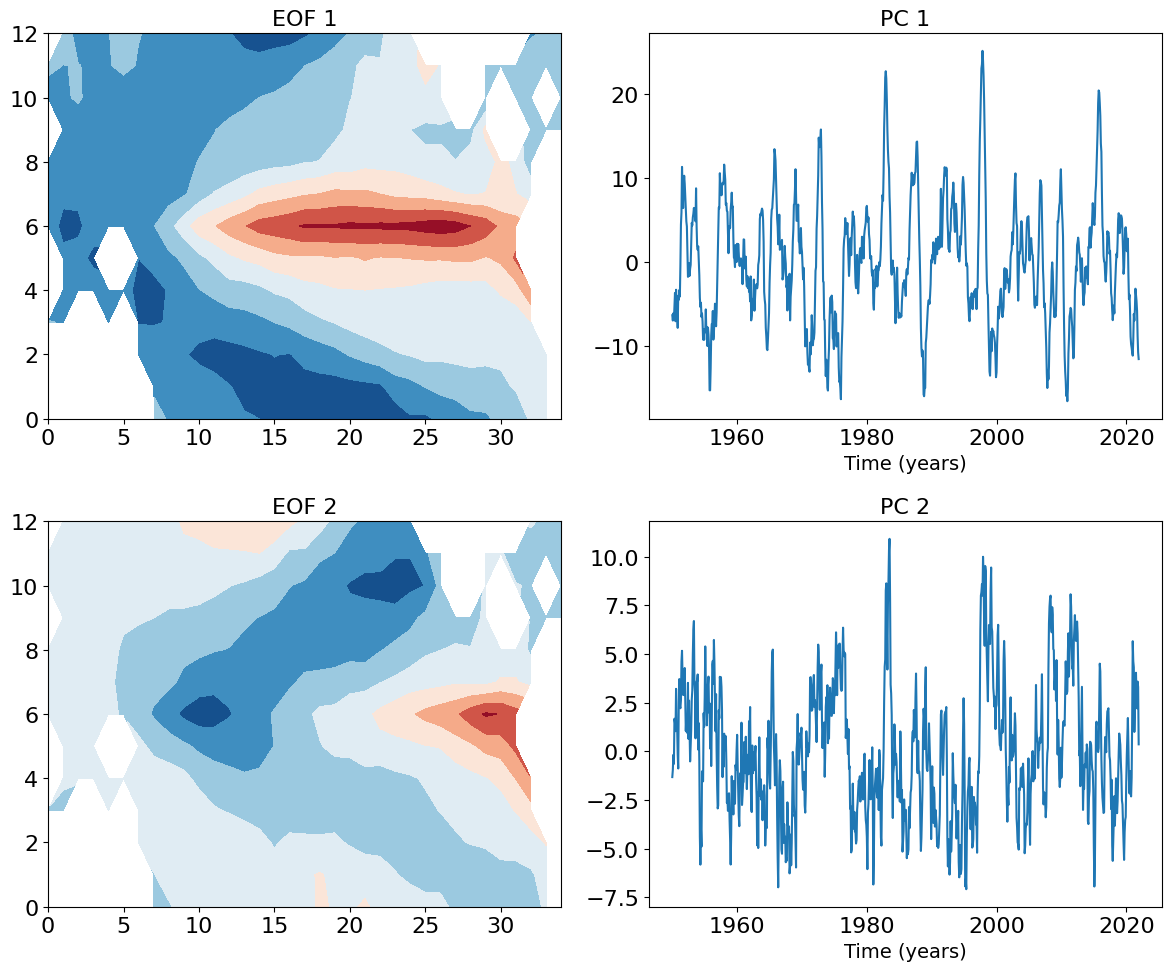

In [80]:
# Set the number of plots to 2
number_of_plots = 2

# Create the figure and axes objects
fig, axs = plt.subplots(number_of_plots, 2, figsize=(12, 10))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    axs[i,0].set_title("EOF {}".format(i + 1), fontsize=16)
    axs[i,0].contourf(eof_10[i], cmap="RdBu_r")
    axs[i,1].set_title("PC {}".format(i + 1), fontsize=16)
    # Define time variable
    time = np.arange(len(pc_10[i]))
    # Convert time to years
    time_years = time/12 + 1950
    # Plot PC with time on x-axis in years
    axs[i,1].plot(time_years, pc_10[i])
    axs[i,1].set_xlabel("Time (years)", fontsize=14)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)

In [81]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]

In [82]:
# Creating an example LIM object

tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)
print("Data train : {} + shape: {}".format(data_train.data, data_train.data.shape))

Frobenius norm: 0.7287977097057688
Data train : [[-6.29767607 -6.92623833 -6.06612333 ... -5.33055296 -4.86835222
  -6.0603949 ]
 [-1.32017403 -0.94989195 -0.17729696 ... -2.09860531 -2.16949402
  -2.62321542]
 [-2.06665347 -2.5961349  -2.8277156  ... -1.22104008 -2.50958123
  -1.09307037]
 ...
 [ 0.46671074  0.63496977  0.63566894 ... -5.22360664 -5.79780068
  -3.26088103]
 [ 1.10638132  0.4535293   0.14078244 ...  1.62794189 -0.17290851
   1.00832557]
 [ 1.5857916   1.44591944  2.32656165 ... -0.99381774 -0.78684863
  -0.79355452]] + shape: (10, 691)


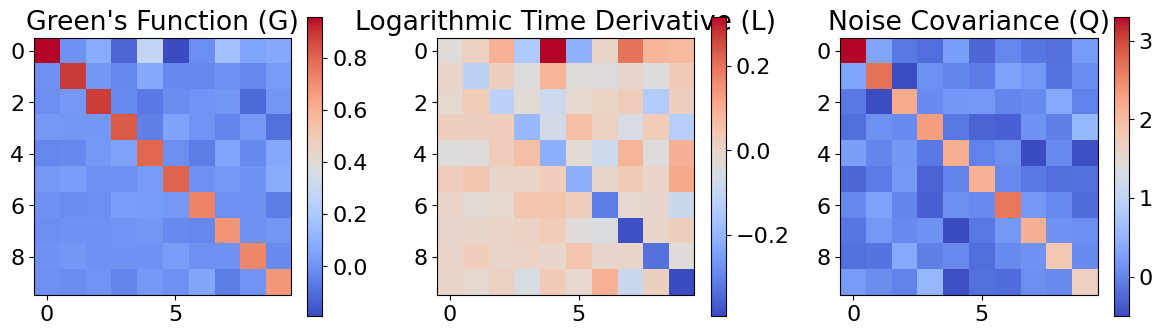

In [83]:
# Plot G, L, Q
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))

# Plot G
im1 = axs[0].imshow(model.green_function, cmap='coolwarm')
axs[0].set_title('Green\'s Function (G)')
fig.colorbar(im1, ax=axs[0])

# Plot L
im2 = axs[1].imshow(np.real(model.logarithmic_matrix), cmap='coolwarm')
axs[1].set_title('Logarithmic Time Derivative (L)')
fig.colorbar(im2, ax=axs[1])

# Plot Q
im3 = axs[2].imshow(np.real(model.noise_covariance), cmap='coolwarm')
axs[2].set_title('Noise Covariance (Q)')
fig.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.show()

In [84]:
# Model geometric brownian motion

#model.geometric_brownian_motion(mu=2)

In [85]:
# Simulate stochastic differential equation

#x_input = data_test.isel(time=0)
x_input = data_test.isel(time=np.arange(0,10))
times = x_input['time']
x = x_input.data

#forecast_output, forecast_output2 = model.forecast(x, [1,2,3])
output_array, state_mid = model.noise_integration(x, timesteps=2000)

forecast_mean = 0
for ensemble in output_array[:-1]:
    forecast_mean += ensemble

forecast_mean = forecast_mean / len(output_array[:-1])
print("Output-Array : {} + shape : {}".format(output_array, output_array.shape))
#print("Forecast mean : {}".format(forecast_mean))


State start : [[-8.08248359e+00 -1.01367106e+01 -1.32250617e+01 -1.49634726e+01
  -1.28233742e+01 -1.39328241e+01 -1.24203107e+01 -8.36445738e+00
  -7.25826169e+00 -5.60614459e+00]
 [-3.38374856e+00 -2.86032138e+00 -8.40633793e-01 -8.78503148e-02
   1.73744915e-01  4.23616190e+00  6.57471905e+00  7.42653553e+00
   7.84993976e+00  7.99710135e+00]
 [-2.15275850e+00 -1.28611473e+00 -2.05043382e+00 -1.30595180e+00
  -2.49540484e-01  1.43357957e+00  9.56076218e-01  7.19482909e-01
   1.39819361e-01 -1.64987456e-01]
 [-7.80833538e-01 -1.53918509e+00 -1.85189513e+00 -1.79460428e+00
  -1.12575954e+00 -1.32392988e+00  2.82374646e+00  2.41559846e+00
   8.02020288e-01 -1.06741491e+00]
 [-2.12457872e+00 -1.16762435e+00 -1.96343620e+00 -3.53964919e+00
  -3.00804837e+00 -1.02828226e+00  1.33471440e+00  3.63004932e+00
   1.56381362e+00  9.08762766e-01]
 [-3.32136790e-01  1.01836801e+00  6.30735710e-01  1.17923654e+00
   1.98360289e+00 -5.73619166e-01 -2.86172890e+00 -3.52808794e+00
  -2.70926864e+00 -

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Reconstructed input data shape: (7, 13, 35)
Reconstructed forecast data shape: (7, 13, 35)


Text(0.5, 1.0, 'Forecast')

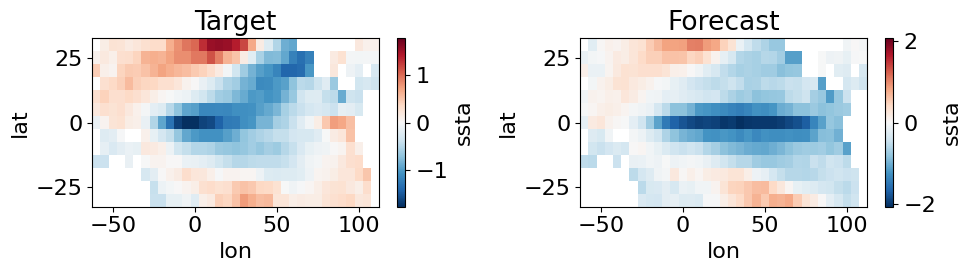

In [86]:
# Transform back to data space (denoted with y) and plot the time evolution of selected components

lag = 3

#x_input = data_test.isel(time=np.arange(0,50))
#x = x_input.data
#TODO plot hinbekommen

# Reconstruct the input and forecasted data
reconstructed_input = pca_10.reconstruction(x[:, lag:], newdim=times[lag:])
reconstructed_forecast = pca_10.reconstruction(output_array[1550, :, :-lag], newdim=times[lag:])

print(f"Reconstructed input data shape: {reconstructed_input.shape}")
print(f"Reconstructed forecast data shape: {reconstructed_forecast.shape}")

# Choose a time index to plot
time_index = 5
time_index2 = 200

# Define plot parameters
plot_params = {'tsa': dict(vmin=-2, vmax=2, eps=0.25),
               'zosa': dict(vmin=-0.1, vmax=.1, eps=0.025)}

# Plot the input and forecasted data at the chosen time index
fig, axs = plt.subplots(1,2, figsize=(10, 3))
reconstructed_input.isel(time=time_index).plot(ax=axs[0])
axs[0].set_title("Target")
reconstructed_forecast.isel(time=time_index).plot(ax=axs[1])
axs[1].set_title("Forecast")

In [87]:
#x_input = data_test.isel(time=0)
x_input = data_test.isel(time=np.arange(0,10))
times = x_input['time']
x = x_input.data

forecast_output, forecast_output2 = model.forecast(x, [1,2,3])

print("Forecast output : {} + shape: {}".format(forecast_output, forecast_output.shape))
print("Forecast2 output : {} + shape: {}".format(forecast_output2, forecast_output2.shape))


Performing LIM forecast for tau values: [1, 2, 3]
Forecast output : [[[-8.70651643e+00 -1.06146153e+01 -1.33943426e+01 -1.53542977e+01
   -1.30942957e+01 -1.24255657e+01 -1.05446359e+01 -6.17118739e+00
   -5.67109429e+00 -4.21461054e+00]
  [-3.21640444e+00 -2.67618302e+00 -9.08644680e-01 -3.40031012e-01
   -1.46495008e-01  3.67610326e+00  5.89713672e+00  6.94469009e+00
    7.09381092e+00  7.16798281e+00]
  [-1.64925504e+00 -9.98023800e-01 -1.57661677e+00 -5.52598813e-01
    1.98973167e-01  1.67117723e+00  9.69738205e-01  6.61132589e-01
    3.68374102e-01  1.53911240e-01]
  [-6.21507083e-01 -1.15084261e+00 -1.54798834e+00 -1.54362834e+00
   -1.02667324e+00 -1.43006091e+00  1.72319620e+00  1.22086786e+00
    2.09991744e-01 -1.08499174e+00]
  [-1.64267802e+00 -8.84949958e-01 -1.32941743e+00 -2.45074575e+00
   -2.07222050e+00 -3.75418211e-01  1.67646715e+00  3.36693495e+00
    1.41174541e+00  5.28895519e-01]
  [-7.44873164e-01  2.71059546e-01  4.39326107e-02  5.18019693e-01
    1.34440119e

In [88]:
#x_input = data_test.isel(time=0)
x_input = data_test.isel(time=np.arange(0,10))
times = x_input['time']
x = x_input.data

forecast_output = model.forecast_mean(x)

print("Forecast output : {} + shape: {}".format(forecast_output, forecast_output.shape))

G_tau: [[ 9.57867917e-01-5.31903577e-17j  1.47020317e-03+4.76889380e-18j
   8.47124358e-02-2.91193952e-17j -1.24971112e-01+3.80489216e-18j
   2.79920460e-01-1.27199345e-16j -1.93040070e-01+8.04586104e-17j
  -1.24229023e-02+4.99828845e-17j  1.69876837e-01-8.12751777e-17j
   5.71155686e-02+1.99731299e-17j  7.05816269e-02-6.89283404e-17j]
 [-1.01493177e-03-1.60656397e-17j  8.87073267e-01-2.73799895e-18j
   1.64052660e-02-2.06265358e-17j -3.39016503e-02+4.27602154e-18j
   7.11441547e-02-9.90223897e-17j -2.96205349e-02+6.49221287e-17j
  -2.98405163e-02+4.61246676e-17j -4.83800060e-03-4.38261916e-17j
  -3.17869172e-02+3.16349779e-17j  2.85930213e-02-4.21871420e-17j]
 [-1.10829640e-02+1.31841751e-17j  2.23051531e-02-6.00159070e-19j
   8.84874876e-01-1.15306462e-16j -2.32238815e-02+5.14958160e-17j
  -6.73041028e-02+1.42107129e-16j -1.36297180e-02+7.19285260e-17j
   5.67338832e-03-3.30260218e-17j  1.45998818e-02+3.57380113e-17j
  -1.12590190e-01+1.11827952e-16j  1.09781775e-02+4.27585629e-18j]


G_tau: [[ 0.82682594-3.80457270e-17j -0.03664032-1.81282727e-17j
   0.22484438-2.08203342e-17j -0.26984778+1.59361767e-17j
   0.64161523-2.08106482e-16j -0.48209501+9.92168255e-17j
  -0.06980085+7.86692476e-17j  0.37307341-5.49473221e-17j
   0.06919939-1.83330436e-17j  0.1845626 -7.66310111e-17j]
 [-0.01367351+1.30598034e-19j  0.68828092+1.09490513e-17j
   0.04132273-2.64015567e-17j -0.0714864 +1.07261454e-17j
   0.14868177-1.48500142e-17j -0.07387708+4.69367705e-17j
  -0.06290234+3.23557936e-17j -0.00245658-1.82077178e-17j
  -0.07227519+2.16266800e-17j  0.07134411-2.87733393e-17j]
 [-0.02466546-4.08935340e-19j  0.04915329+2.30107404e-18j
   0.68742757-7.58377960e-17j -0.05873498+6.55643273e-17j
  -0.14175585+6.81842691e-17j -0.03608937+1.94092578e-17j
   0.02180695+7.52645920e-19j  0.01351899+1.00759818e-17j
  -0.21776229+2.06075849e-17j  0.01676235-5.75429980e-18j]
 [ 0.05405973-3.35784775e-17j  0.04787398-1.36151643e-17j
   0.0381453 -1.99384667e-18j  0.55217901-5.44666949e-17j
  -0

Text(0.5, 0, 'Time')

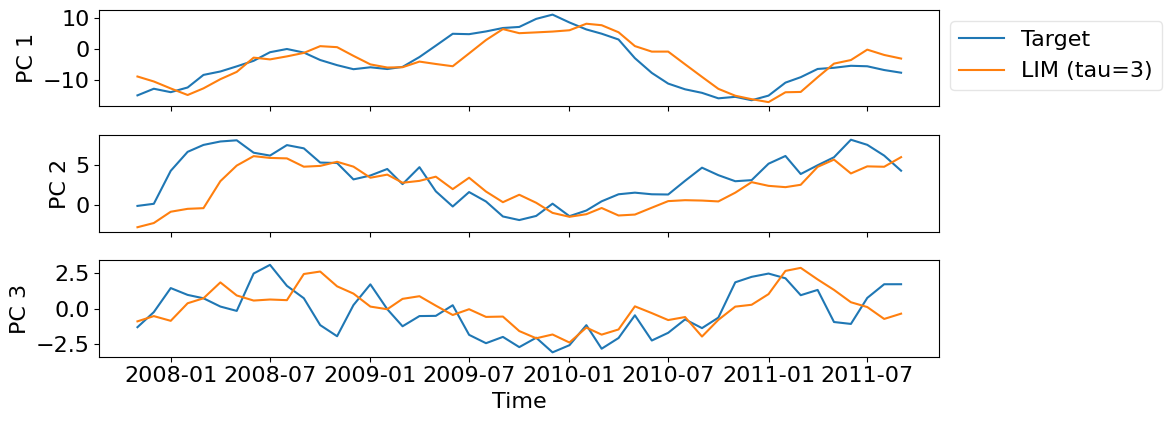

In [89]:
# Forecasting

# Define lag
lag = 3

# Get input data
x_input = data_test.isel(time=np.arange(0, 50))
times = x_input['time']
x = x_input.data

# Forecast mean using LIM model
x_frcst = model.forecast_mean(x, lag=lag)

# Plot time evolution of selected components
idx_components = [0, 1, 2]
fig, axs = plt.subplots(len(idx_components), figsize=(12, len(idx_components)*1.5), sharex=True)

for i, component in enumerate(idx_components):
    # Plot target data for the component
    axs[i].plot(times[lag:], x[component, lag:], label='Target')

    # Plot forecasted data using LIM model
    axs[i].plot(times[lag:], x_frcst[component, :-lag], label=f'LIM (tau={lag})')

    # Set y-axis label
    axs[i].set_ylabel(f'PC {component+1}')

# Add legend
_ = axs[0].legend(bbox_to_anchor=(1, 1), loc="upper left")

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Time')

Reconstructed input data shape: (47, 13, 35)
Reconstructed forecast data shape: (47, 13, 35)


Text(0.5, 1.0, 'Forecast')

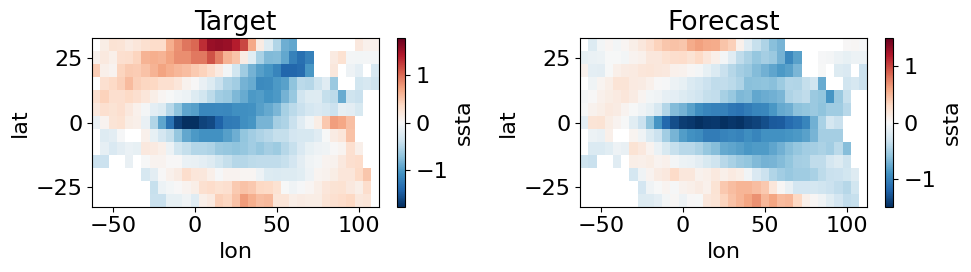

In [90]:
# Transform back to data space (denoted with y) and plot the time evolution of selected components

# Reconstruct the input and forecasted data
reconstructed_input = pca_10.reconstruction(x[:, lag:], newdim=times[lag:])
reconstructed_forecast = pca_10.reconstruction(x_frcst[:, :-lag], newdim=times[lag:])

print(f"Reconstructed input data shape: {reconstructed_input.shape}")
print(f"Reconstructed forecast data shape: {reconstructed_forecast.shape}")

# Choose a time index to plot
time_index = 5

# Define plot parameters
plot_params = {'tsa': dict(vmin=-2, vmax=2, eps=0.25),
               'zosa': dict(vmin=-0.1, vmax=.1, eps=0.025)}

# Plot the input and forecasted data at the chosen time index
fig, axs = plt.subplots(1,2, figsize=(10, 3))
reconstructed_input.isel(time=time_index).plot(ax=axs[0])
axs[0].set_title("Target")
reconstructed_forecast.isel(time=time_index).plot(ax=axs[1])
axs[1].set_title("Forecast")